# Creating Dataloaders using `torch-em`

The tutorial is focused on creating dataloaders using `torch-em` for various segmentation tasks. Let's get started.

The first thing to do would be to make sure that we have `torch-em` installed and accessible in the notebook kernel.

In [1]:
_found_torch_em = False

URL = "https://github.com/constantinpape/torch-em#installation"  # documentation for installing 'torch-em'

try:
    import torch_em
    print("Yayy, we found 'torch-em'. Start creating your dataloaders already. Skip to Step 0.")
    _found_torch_em = True
except ModuleNotFoundError:
    print(f"'torch-em' was not found. Please install it from {URL}")

Yayy, we found 'torch-em'. Start creating your dataloaders already. Skip to Step 0.


If the output above suggests to install `torch-em`, you need to install all the relevant [packages](https://github.com/constantinpape/torch-em?tab=readme-ov-file#installation).

Let's check where are you now?

In [2]:
# overwrite for the online notebooks you are using
using_colab = False
using_kaggle = False

In [3]:
import os
current_spot = os.getcwd()

resource_status = (using_colab + using_kaggle)
assert resource_status <= 1, "Oops, you can't be on both Kaggle and Colab at the same time, please choose one!"

if current_spot.startswith("/content") or using_colab:
    using_colab = True
    print("Google Colab says hi!")
elif current_spot.startswith("/kaggle/working") or using_kaggle:
    using_kaggle = True
    print("Kaggle Notebook says hi!")
else:
    if _found_torch_em:
        print("You have 'torch-em' installed already.")
    else:
        print("You are using a behind-the-scenes resource. Follow our installation instructions here.")

You have 'torch-em' installed already.


In [4]:
# Now that we are aware of our setup, let's carefully install 'torch-em'
# TODO: test this on Kaggle / Colab
if not _found_torch_em:
    !git clone https://github.com/constantinpape/torch-em
    !pip install ${current_spot}/torch-em

Ideally, this should not throw any errors. If there are some modules missing, please go ahead and install them.

## Step 0: Let's explore our datasets

We will follow the process of creating dataloaders from two different open-source datasets (already supported by torch-em), and learn how to create dataloaders (for an unsupported dataset as well in the end) for training a UNet architecture. The choice of datasets are following:

1. DSB (Nuclei Segmentation in Light Microscopy: Caicedo et al. - https://doi.org/10.1038/s41592-019-0612-7)
    - 2d images with instance labels
2. PlantSeg (Cell Segmentation in Confocal and Light-Sheet Microscopy: Wolny et al. - https://doi.org/10.7554/eLife.57613)
    - 3d images with instance labels

In [5]:
# First, import all the necessary libraries
import h5py
import numpy as np
from glob import glob

import imageio.v3 as imageio
from matplotlib import colors
import matplotlib.pyplot as plt

from torch_em.data import datasets
from torch_em.util.debug import check_loader
from torch_em import default_segmentation_dataset, get_data_loader
from torch_em.transform.label import labels_to_binary, BoundaryTransform

try:
    import napari
    _found_napari = True
except ModuleNotFoundError:
    _found_napari = False
    assert (using_colab + using_kaggle) == 0, "napari does not work on Kaggle / Colab."
    print("Please install 'napari' if you are using local resources and want to visualize using napari.")

In [6]:
DATA_DIR = "/media/anwai/ANWAI/data/"  # overwrite the path where you want to download the open-source datasets (don't worry, 'torch-em' will automatically download them for you)

In [7]:
# Let's get all the convenience functions for the tutorial

def _fetch_datasets(dataset_name, path, download=True):
    if dataset_name == "dsb":
        datasets.dsb._download_dsb(path, "reduced", download=download)
        data_path = path

    elif dataset_name == "plantseg_root":
        data_path = datasets.plantseg._require_plantseg_data(path, download=download, name="root", split="test")

    else:
        raise ValueError(f"Oops, download is not enabled for {dataset_name}.")

    return data_path

# TODO: add this in torch-em, it's a good function to have
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap


def plot_samples(image, labels, cmap="gray", view_napari=False):
    def _get_mpl_plots(image, labels):
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image, cmap=cmap)
        ax[0].axis("off")
        ax[0].set_title("Image")

        ax[1].imshow(labels, cmap=get_random_colors(labels), interpolation="nearest")
        ax[1].axis("off")
        ax[1].set_title("Labels")
        plt.show()

    if view_napari:
        if _found_napari:
            v = napari.Viewer()
            v.add_image(image)
            v.add_labels(labels)
            napari.run()
        else:
            print("Couldn't spot 'napari' to visualize the image, please make 'view_napari' to False and visualize the images in matplotlib.")
    else:
        _get_mpl_plots(image, labels)

In [8]:
dsb_path = _fetch_datasets(dataset_name="dsb", path=os.path.join(DATA_DIR, "dsb"), download=True)
plantseg_root_path = _fetch_datasets(dataset_name="plantseg_root", path=os.path.join(DATA_DIR, "plantseg_root"), download=True)

Download https://files.de-1.osf.io/v1/resources/tn4xj/providers/osfstorage/?zip= to /media/anwai/ANWAI/data/plantseg_root/root_test.zip (unknown file size): 324MB [00:33, 10.2MB/s] 
/home/anwai/torch-em/torch_em/data/datasets/util.py:68: UserWarning: The file was downloaded, but no checksum was provided, so the file may be corrupted.
  warn("The file was downloaded, but no checksum was provided, so the file may be corrupted.")


Our dataset is downloaded. Let's explore them quickly before proceeding to create the dataset object.

The image extension seems to be: .tif
The label extension seems to be: .tif


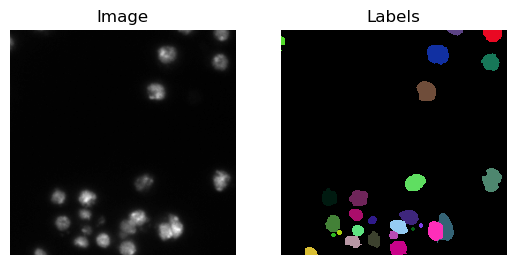

In [9]:
# For DSB
# Explore where your inputs are stored, and provide the names for them here
# We see that the DSB dataset has two splits: 'train' and 'test'
# For simplicity, let's go ahead with the 'train' data and check it out
#   - We observe that 'train' has two sub-directores: 'images' (input images, ) and 'masks' (instance labels)
# Let's check them out and understand the data better.

# First, we get all the images in the sub-directories.
image_paths = sorted(glob(os.path.join(dsb_path, "train", "images", "*")))
label_paths = sorted(glob(os.path.join(dsb_path, "train", "masks", "*")))

# We need to know the file type to explore the images in the dataset. Let's check it out
print("The image extension seems to be:", os.path.splitext(image_paths[0])[-1])
print("The label extension seems to be:", os.path.splitext(label_paths[0])[-1])

# It appears that the images are in tif format. It's a supported data format. Now let's check how the data looks.
image_shapes = [imageio.imread(path).shape for path in image_paths]
label_shapes = [imageio.imread(path).shape for path in label_paths]

# Q. check the input shapes from above, are they consistently the same for all images? are they one channel or more than one?

# It appears that the images have a consistent shape throughout and have one input channel. It's a supported data structure as well. Now let's visualize one image to understand our data better.
for image_path, label_path in zip(image_paths, label_paths):
    image = imageio.imread(image_path)
    labels = imageio.imread(label_path)

    plot_samples(image, labels)

    break  # it's enough to check a few samples, feel free to explore the entire dataset

In [10]:
# For PlantSeg
# Explore where your inputs are stored, and provide the names for them here
# We see that the PlantSeg (Root) dataset has many volumes with '.h5' extension.
# For simplicity, let's go ahead with the 'test' split and check it out
#   - We observe that 'test' has four volumes.
# Let's check them out and understand the data better.

# First, we get all the volumes.
volume_paths = glob(os.path.join(plantseg_root_path, "*"))

# We need to know the file type to explore the images in the dataset. Let's check it out
print("The volume extension seems to be:", os.path.splitext(volume_paths[0])[-1])

# It appears that the images are in hdf5 format. It's a supported data format. Now let's check how the data looks.
# NOTE: If you are new to hdf5 format, check this out (for installation and quick-start instructions - https://docs.h5py.org/)
chosen_volume = volume_paths[0]
with h5py.File(chosen_volume) as f:
    image = f["raw"][:]
    label = f["label"][:]

    print("The image volume and label volume respectively are:", image.shape, label.shape)

    # it's enough to check a few samples, feel free to explore the entire dataset
    # NOTE: since it's a 3d volume, we recommend visualizing it using napari (downside: napari does not work on Kaggle / Colab)
    # Suggestion: if you want to stick to matplotlib, view the volume slice-by-slice, or write your own script for custom visualization.
    plot_samples(image, label, view_napari=True)

The volume extension seems to be: .h5
The image volume and label volume respectively are: (486, 620, 1330) (486, 620, 1330)


## Step 1: Let's create the dataset

In [11]:
# (A) DSB dataset
# We observe that all the inputs are one-channel tif images, and their labels are instance segmentation.
# Let's say, the task is to perform foreground (nuclei) segmentation.
# Now, let's create a dataset for semantic nuclei labels.

# dataset parameters
patch_shape = (256, 256)
file_description = "*.tif"  # this is the search description to look for files in your respective directories

dsb_dataset = default_segmentation_dataset(
    raw_paths=os.path.join(dsb_path, "train", "images"),  # the image directory
    raw_key=file_description,
    label_paths=os.path.join(dsb_path, "train", "masks"),  # the labels directory
    label_key=file_description,
    patch_shape=patch_shape,
    label_transform=labels_to_binary,  # remember the task above for semantic nuclei labels? this function takes care of it.*
    ndim=2  # the number of input dimensions (i.e. two for the provided images)
)

In [12]:
# (B) PlantSeg dataset
# We observe that all the inputs are volumes, with a different number of slices in each stack
# Let's say, the task here is to perform boundary segmentation.
# Now, let's create a dataset for semantic boundary labels.

# datasets parameters
patch_shape = (1, 512, 512)
volume_paths = glob(os.path.join(plantseg_root_path, "*.h5"))  # paths of all the volumes

plantseg_root_dataset = default_segmentation_dataset(
    raw_paths=volume_paths,
    raw_key="raw",  # this is the hierarchy in the hdf5 files, where the images are stored
    label_paths=volume_paths,
    label_key="label",   # this is the hierarchy in the hdf5 files, where the labels are stored
    patch_shape=patch_shape,
    label_transform=BoundaryTransform(),  # remember the task above for semantic boundary labels? this function takes care of it.*
    ndim=2,
    
)

*NOTE: We observe that some custom functions are passed to `label_transform`. The idea is to convert the labels on-the-fly without destroying the original inputs, for optimal flexibility. Here's how you can create and pass your custom label transforms:

```python
def custom_defined_label_transform(labels):
    labels = ...  # use desired methods to convert the labels to a desired target format.
    return labels


dataset = torch_em.default_segmentation_dataset(
    ...,
    label_transform=custom_defined_label_transform,
)
```

The same method can be applied for `raw_transform`, however, be careful as it overrides the default transforms (i.e, input normalization)

## Step 2: Let's create the dataloader

In [13]:
# DSB dataloader
dsb_loader = get_data_loader(dsb_dataset, batch_size=2)

In [14]:
# PlantSeg dataloader
plantseg_root_loader = get_data_loader(plantseg_root_dataset, batch_size=2)

The dataloaders above are straight-forward. They take the input arguments the same as PyTorch data loaders. The often desired ones are: `num_workers=16`, `shuffle=True`, etc.

## Step 3: Let's check our dataloaders

In [15]:
def look_at_chosen_loader(chosen_loader, do_run=False):
    if do_run:
        save_path = f"./loader.png"
        print("Let's check how the samples look first. We store the images here:", save_path)
        check_loader(chosen_loader, 8, plt=True)
    else:
        print(f"There are {len(chosen_loader)} samples generated from the loader. Please pass 'do_run=True' to 'look_at_chosen_loader' function for visualizing the samples.")
        return

    for x, y in chosen_loader:
        print("For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape")
        break  # checking out the shape of one sample is enough, feel free to explore for the entire dataset

Let's check how the samples look first. We store the images here: ./loader.png


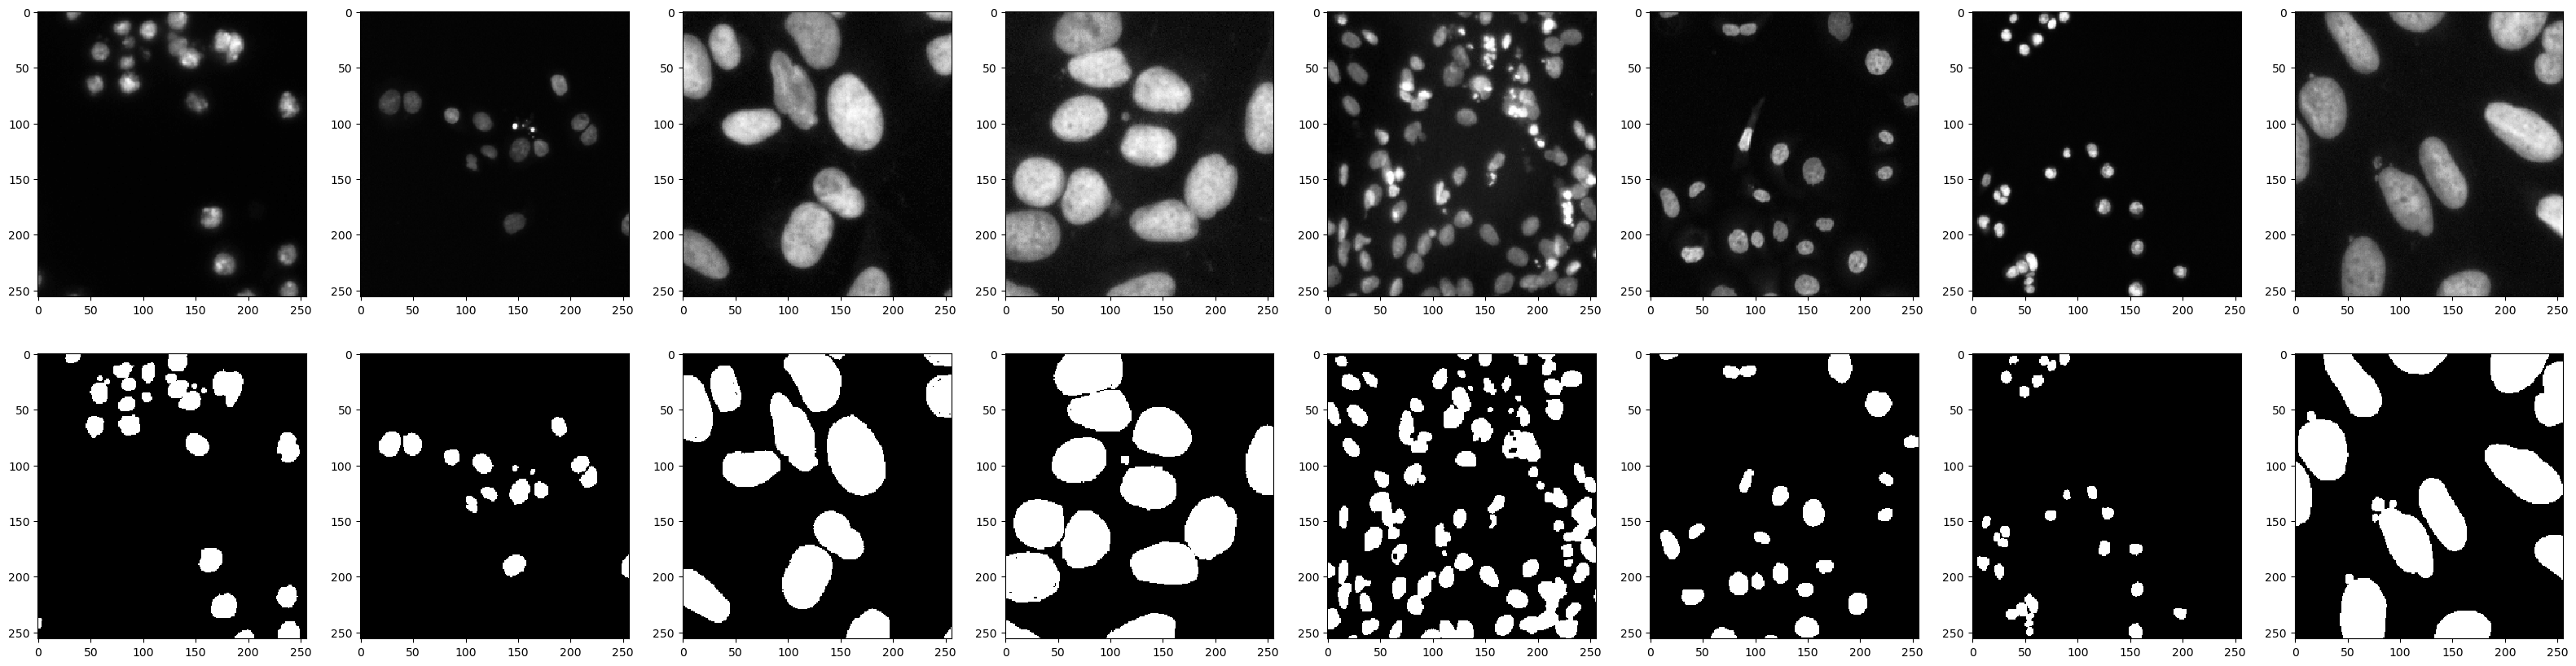

For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape


In [16]:
# Visualize DSB dataloader
look_at_chosen_loader(dsb_loader, do_run=True)

Let's check how the samples look first. We store the images here: ./loader.png


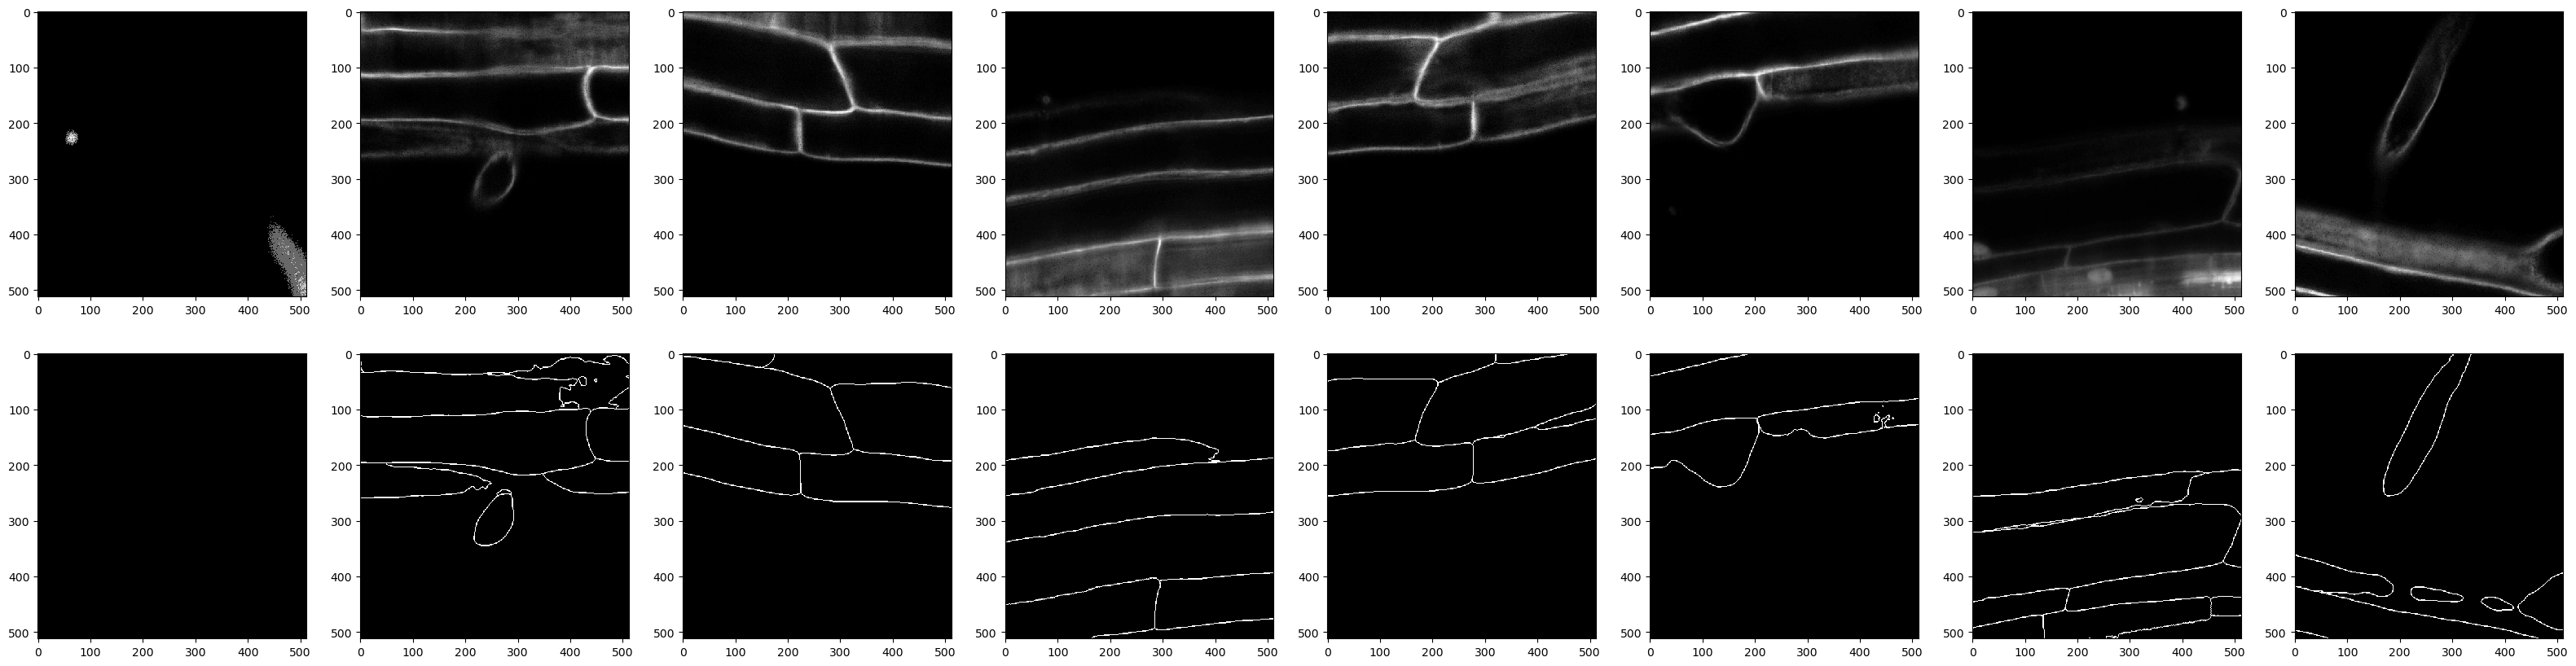

For each batch, the inputs are of shape: {x.shape}; and the labels are of shape: y.shape


In [17]:
# Visualize PlantSeg (Root) dataloader
look_at_chosen_loader(plantseg_root_loader, do_run=True)

## Congratulations!

You are now ready to create your own dataloaders and train your deep learning models at ease.

Want to practice your skills learned? Here is an open-source 3d dataset: [Lucchi++](http://www.casser.io/files/lucchi_pp.zip): Segmentation of mitochondria in electron microscopy (Reference: https://doi.org/10.48550/arXiv.1812.06024)

In [ ]:
# TODO: Create your own dataloaders. Have fun! :)